# Comparing matrix factorization with transformers for MovieLens recommendations using PyTorch-accelerated.

By Chris Hughes

The package versions used are:

In [1]:
from torch.utils.data import DataLoader
import numpy as np
import torch
from tqdm.notebook import tqdm
import time
import datetime
import os

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
train_joke_df = pd.read_csv(r'data\recsys-in-practice\train_joke_df.csv')
sample_submission = pd.read_csv(r'data\recsys-in-practice\sample_submission.csv')

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
train_df, valid_df = train_test_split(train_joke_df, test_size=0.5, random_state=42)

Even when considering model benchmarks on the same dataset, to have a fair comparison, it is important to understand how the data has been split and to make sure that the approaches taken are consistent!

In [6]:
user_lookup = {v: i+1 for i, v in enumerate(train_joke_df["UID"].unique())}

In [7]:
movie_lookup = {v: i+1 for i, v in enumerate(train_joke_df["JID"].unique())}

Now that we can encode our features, as we are using PyTorch, we need to define a Dataset to wrap our DataFrame and return the user-item ratings.

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
from torch.utils.data import Dataset

class UserItemRatingDataset(Dataset):
    def __init__(self, df, movie_lookup, user_lookup):
        self.df = df
        self.movie_lookup = movie_lookup
        self.user_lookup = user_lookup

    def __getitem__(self, index):
        row = self.df.iloc[index]
        user_id = torch.tensor(self.user_lookup[row.UID]).to(device)
        movie_id = torch.tensor(self.movie_lookup[row.JID]).to(device)
        
        rating = torch.tensor(row.Rating, dtype=torch.float32).to(device)
        
        return (user_id, movie_id), rating

    def __len__(self):
        return len(self.df)


We can now use this to create our training and validation datasets:

In [10]:
train_dataset = UserItemRatingDataset(train_df, movie_lookup, user_lookup)
valid_dataset = UserItemRatingDataset(valid_df, movie_lookup, user_lookup)

Next, let's define the model.

In [11]:
import torch
from torch import nn

class MfDotBias(nn.Module):

    def __init__(self, n_factors, n_users, n_items, ratings_range=None, use_biases=True):
        super().__init__()
        self.bias = use_biases
        self.y_range = ratings_range
        self.user_embedding = nn.Embedding(n_users+1, n_factors, padding_idx=0)
        self.item_embedding = nn.Embedding(n_items+1, n_factors, padding_idx=0)

        if use_biases:
            self.user_bias = nn.Embedding(n_users+1, 1, padding_idx=0)
            self.item_bias = nn.Embedding(n_items+1, 1, padding_idx=0)

    def forward(self, inputs):
        users, items = inputs
        dot = self.user_embedding(users) * self.item_embedding(items)
        result = dot.sum(1)
        if self.bias:
            result = (result + self.user_bias(users).squeeze() + self.item_bias(items).squeeze())

        if self.y_range is None:
            return result
        else:
            return (torch.sigmoid(result) * (self.y_range[1] - self.y_range[0]) + self.y_range[0])

As we can see, this is very simple to define. Note that because an embedding layer is simply a lookup table, it is important that when we specify the size of the embedding layer, it must contain any value that will be seen during training and evaluation. Because of this, we will use the number of unique items observed in the full dataset to do this, not just the training set. We have also specified a padding embedding at index 0, which can be used for any unknown values. PyTorch handles this by setting this entry to a zero-vector, which is not updated during training.

Additionally, as this is a regression task, the range that the model could predict is potentially unbounded. While the model can learn to restrict the output values to between 1 and 5, we can make this easier for the model by modifying the architecture to restrict this range prior to training. We have done this by applying the sigmoid function to the model's output - which restricts the range to between 0 and 1 - and then scaling this to within a range that we can define.

### Train with PyTorch accelerated

At this point, we would usually start writing the training loop; however, as we are using pytorch-accelerated, this will largely be taken care of for us. However, as pytorch-accelerated tracks only the training and validation losses by default, let's create a callback to track our metrics.

Let's create a callback to track our metrics

Now, all that is left to do is to train the model. PyTorch-accelerated provides a notebook_launcher function, which enables us to run multi-GPU training runs from within a notebook. To use this, all we need to do is to define a training function that instantiates our Trainer object and calls the train method.

Components such as the model and dataset can be defined anywhere in the notebook, but it is important that the trainer is only ever instantiated within a training function.

In [15]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def save(model, name):
    os.mkdir(f"artifacts_wonderfund_v1/{name}")
    #torch.save(model, f"{name}/model.pkl")
    torch.save(model.state_dict(), f"artifacts_wonderfund_v1/{name}/checkpoint.pth")
    
def load(name):
    return torch.load(f"artifacts_wonderfund_v1/{name}/model.pkl")

def load2(name, model):
    model.load_state_dict(torch.load(f"artifacts_wonderfund_v1/{name}/checkpoint.pth"))
    
def train_model(epoch_start, model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler, loss_train_history, loss_val_history):   
    bet_model_name = None
    best_loss = compute_accuracy(model, val_loader, loss)
    print('loss:', best_loss)
    for epoch in range(epoch_start, epoch_start + num_epochs):     
        t1 = time.time()
        model.train()   
        loss_accum = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()            
            loss_accum += loss_value

            
        
        ave_loss = loss_accum / (i_step + 1)
        loss_val = compute_accuracy(model, val_loader, loss)
        
        loss_train_history.append(float(ave_loss))
        loss_val_history.append(loss_val)
        
        if scheduler != None:
            scheduler.step()
            

        if loss_val < best_loss:
            best_loss = loss_val
            bet_model_name = f'{datetime.datetime.now().strftime("%d.%m.%Y_%H.%M.%S.%f")}_epoch_{epoch}_loss_{round(best_loss, 4)}'
            save(model, bet_model_name)
            print(f"saved {bet_model_name}")

            
        print("Epoch: %i lr: %f; Train loss: %f, Val loss: %f, time: %i s" % (epoch, get_lr(optimizer), ave_loss, loss_val,
                                                                            round(time.time() - t1)))
    return bet_model_name
        
    
def compute_accuracy(model, loader, loss):
    """
    Computes accuracy on the dataset wrapped in a loader    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    loss_accum = 0
    for i_step, (x, y) in enumerate(loader):
        prediction = model(x)
        loss_value = loss(prediction, y)
        loss_accum += loss_value

    ave_loss = loss_accum / (i_step + 1)         
    return float(ave_loss)

In [16]:
def RMSE_loss(prediction, target):
    return torch.sqrt(nn.MSELoss()(prediction, target))

In [19]:
model = MfDotBias(120, len(user_lookup), len(movie_lookup), ratings_range=[-10, 10]).to(device)
loss_train_history, loss_val_history = [], []

best_model_name = '22.04.2023_19.04.16.683005_epoch_14_loss_5.6441'
load2(best_model_name, model)

In [21]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.015)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

bet_model_name = train_model(8,
    model, 
    DataLoader(train_dataset, batch_size=10000),
    DataLoader(valid_dataset, batch_size=10000),
    RMSE_loss, optimizer, 100, scheduler, loss_train_history, loss_val_history)
print('end!')

loss: 5.644097328186035
saved 22.04.2023_19.57.49.619482_epoch_8_loss_5.5739
Epoch: 8 lr: 0.001000; Train loss: 3.263098, Val loss: 5.573893, time: 325 s
saved 22.04.2023_20.03.20.593287_epoch_9_loss_5.5515
Epoch: 9 lr: 0.001000; Train loss: 3.125072, Val loss: 5.551464, time: 331 s
saved 22.04.2023_20.08.39.395928_epoch_10_loss_5.5431
Epoch: 10 lr: 0.001000; Train loss: 3.056410, Val loss: 5.543149, time: 319 s
saved 22.04.2023_20.14.01.899971_epoch_11_loss_5.541
Epoch: 11 lr: 0.001000; Train loss: 3.000063, Val loss: 5.541049, time: 323 s
Epoch: 12 lr: 0.000800; Train loss: 2.947003, Val loss: 5.542380, time: 322 s
Epoch: 13 lr: 0.000800; Train loss: 2.890984, Val loss: 5.544814, time: 324 s
Epoch: 14 lr: 0.000800; Train loss: 2.849479, Val loss: 5.548423, time: 319 s
Epoch: 15 lr: 0.000800; Train loss: 2.808391, Val loss: 5.552837, time: 335 s


KeyboardInterrupt: 

In [30]:
dataset = UserItemRatingDataset(train_joke_df, movie_lookup, user_lookup)

In [34]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

bet_model_name = train_model(21,
    model, 
    DataLoader(dataset, batch_size=10000),
    DataLoader(valid_dataset, batch_size=10000),
    RMSE_loss, optimizer, 6, None, loss_train_history, loss_val_history)
print('end!')

loss: 5.103021144866943
saved 22.04.2023_22.02.45.464659_epoch_21_loss_5.0474
Epoch: 21 lr: 0.000100; Train loss: 4.107443, Val loss: 5.047354, time: 491 s
saved 22.04.2023_22.11.02.175916_epoch_22_loss_4.9955
Epoch: 22 lr: 0.000100; Train loss: 4.080122, Val loss: 4.995517, time: 497 s
saved 22.04.2023_22.19.21.217493_epoch_23_loss_4.9479
Epoch: 23 lr: 0.000100; Train loss: 4.056099, Val loss: 4.947924, time: 499 s
saved 22.04.2023_22.27.42.082419_epoch_24_loss_4.9043
Epoch: 24 lr: 0.000100; Train loss: 4.034567, Val loss: 4.904278, time: 501 s
saved 22.04.2023_22.36.11.670000_epoch_25_loss_4.8642
Epoch: 25 lr: 0.000100; Train loss: 4.015214, Val loss: 4.864242, time: 510 s


KeyboardInterrupt: 

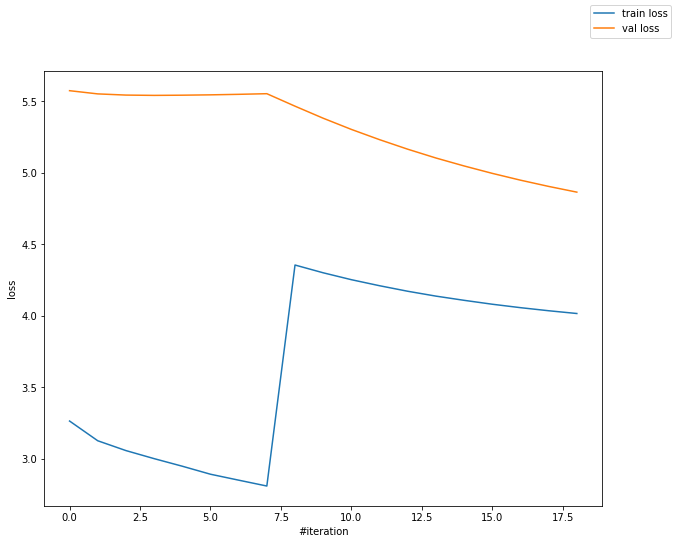

In [35]:
fig = plt.figure(figsize=(10, 8))    
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_train_history, label='train loss')
plt.plot(loss_val_history, label='val loss')
fig.legend()
plt.show()

In [ ]:
assert False

In [36]:
test_joke_df_nofactrating = pd.read_csv(r'data\recsys-in-practice\test_joke_df_nofactrating.csv', index_col=0)

test_joke_df_nofactrating['Rating'] = np.zeros((len(test_joke_df_nofactrating)))

In [37]:
test_dataset = UserItemRatingDataset(test_joke_df_nofactrating, movie_lookup, user_lookup)

In [38]:
best_model_name = '22.04.2023_22.36.11.670000_epoch_25_loss_4.8642'

best_model = MfDotBias(120, len(user_lookup), len(movie_lookup), ratings_range=[-10, 10]).to(device)
print(compute_accuracy(best_model, DataLoader(test_dataset, batch_size=5000), RMSE_loss))

load2(best_model_name, best_model)
print(compute_accuracy(best_model, DataLoader(test_dataset, batch_size=5000), RMSE_loss))

9.251912117004395
4.338476181030273


In [39]:
result = []
for x, y in tqdm(DataLoader(test_dataset, batch_size=5000)):
    predict = model(x)
    result.extend(predict.cpu().detach().numpy())

  0%|          | 0/73 [00:00<?, ?it/s]

In [40]:
test_joke_df_nofactrating['Rating'] = result

In [41]:
test_joke_df_nofactrating['Rating'].to_frame().head(5)

,Rating
InteractionID,
0,3.364809
1,-3.937026
2,-2.542684
3,6.760567
4,5.356848


In [42]:
test_joke_df_nofactrating['Rating'].to_frame().to_csv('nn_embedding.csv')

In [ ]:
assert False

Comparing this to our baseline, we can see that there is an improvement!

## Sequential recommendations using a transformer

Using matrix factorization, we are treating each rating as being independent from the ratings around it; however, incorporating information about other movies that a user recently rated could provide an additional signal that could boost performance. For example, suppose that a user is watching a trilogy of films; if they have rated the first two instalments highly, it is likely that they may do the same for the finale!

One way that we can approach this is to use a transformer network, specifically the encoder portion, to encode additional context into the learned embeddings for each movie, and then using a fully connected neural network to make the rating predictions.

### Pre-processing the data

The first step is to process our data so that we have a time-sorted list of movies for each user. Let's start by grouping all the ratings by user:

In [ ]:
grouped_ratings = train_joke_df.groupby('UID').agg(tuple).reset_index()

In [ ]:
grouped_ratings

Now that we have grouped by user, we can create an additional column so that we can see the number of events associated with each user

In [ ]:
grouped_ratings['num_ratings'] = grouped_ratings['Rating'].apply(lambda row: len(row))

Let's take a look at the new dataframe

In [ ]:
grouped_ratings

Now that we have grouped all the ratings for each user, let's divide these into smaller sequences. To make the most out of the data, we would like the model to have the opportunity to predict a rating for every movie in the training set. To do this, let's specify a sequence length s and use the previous s-1 ratings as our user history.

As the model expects each sequence to be a fixed length, we will fill empty spaces with a padding token, so that sequences can be batched and passed to the model. Let's create a function to do this.

We are going to arbitrarily choose a length of 10 here.

In [ ]:
sequence_length = 10

In [ ]:
def create_sequences(values, sequence_length):
    sequences = []
    for i, v in enumerate(values):
        seq = values[:i+1]
        if len(seq) > sequence_length:
            seq = seq[i-sequence_length+1:i+1]
        elif len(seq) < sequence_length:
            seq =(*(['[PAD]'] * (sequence_length - len(seq))), *seq)
       
        sequences.append(seq)
    return sequences
        

To visualize how this function works, let's apply it, with a sequence length of 3, to the first 10 movies rated by the first user. These movies are:

In [ ]:
grouped_ratings.iloc[0]['title'][:10]

Applying our function, we have:

In [ ]:
create_sequences(grouped_ratings.iloc[0]['JID'][:10], 3)

As we can see, we have 10 sequences of length 3, where the final movie in the sequence is unchanged from the original list.

Now, let's apply this function to all of the features in our dataframe

In [ ]:
grouped_cols = ['title', 'rating', 'unix_timestamp', 'is_valid'] 
for col in grouped_cols:
    grouped_ratings[col] = grouped_ratings[col].apply(lambda x: create_sequences(x, sequence_length))

In [ ]:
grouped_ratings.head(2)

Currently, we have one row that contains all the sequences for a certain user. However, during training, we would like to create batches made up of sequences from many different users. To do this, we will have to transform the data so that each sequence has its own row, while remaining associated with the user ID. We can use the pandas 'explode' function for each feature, and then aggregate these DataFrames together.

In [ ]:
exploded_ratings = grouped_ratings[['user_id', 'title']].explode('title', ignore_index=True)
dfs = [grouped_ratings[[col]].explode(col, ignore_index=True) for col in grouped_cols[1:]]
seq_df = pd.concat([exploded_ratings, *dfs], axis=1)

In [ ]:
seq_df.head()

Now, we can see that each sequence has its own row. However, for the is_valid column, we don't care about the whole sequence and only need the last value as this is the movie for which we will be trying to predict the rating. Let's create a function to extract this value and apply it to these columns.

In [ ]:
def get_last_entry(sequence):
    return sequence[-1]

seq_df['is_valid'] = seq_df['is_valid'].apply(get_last_entry)

In [ ]:
seq_df

Also, to make it easy to access the rating that we are trying to predict, let's separate this into its own column.

In [ ]:
seq_df['target_rating'] = seq_df['rating'].apply(get_last_entry)
seq_df['previous_ratings'] = seq_df['rating'].apply(lambda seq: seq[:-1])
seq_df.drop(columns=['rating'], inplace=True)

To prevent the model from including padding tokens when calculating attention scores, we can provide an attention mask to the transformer; the mask should be 'True' for a padding token and 'False' otherwise. Let's calculate this for each row, as well as creating a column to show the number of padding tokens present.

In [ ]:
seq_df['pad_mask'] = seq_df['title'].apply(lambda x: (np.array(x) == '[PAD]'))
seq_df['num_pads'] = seq_df['pad_mask'].apply(sum)
seq_df['pad_mask'] = seq_df['pad_mask'].apply(lambda x: x.tolist()) # in case we serialize later

Let's inspect the transformed data

In [ ]:
seq_df

All looks as it should! Let's split this into training and validation sets and save this.

In [ ]:
train_seq_df = seq_df[seq_df.is_valid == False]
valid_seq_df = seq_df[seq_df.is_valid == True]

### Training the model

As we saw previously, before we can feed this data into the model, we need to create lookup tables to encode our movies and users. However, this time, we need to include the padding token in our movie lookup.

In [ ]:
user_lookup = {v: i+1 for i, v in enumerate(ratings_df['user_id'].unique())}

In [ ]:
def create_feature_lookup(df, feature):
    lookup = {v: i+1 for i, v in enumerate(df[feature].unique())}
    lookup['[PAD]'] = 0
    return lookup

In [ ]:
movie_lookup = create_feature_lookup(ratings_df, 'title')

Now, we are dealing with sequences of ratings, rather than individual ones, so we will need to create a new dataset to wrap our processed DataFrame:

In [ ]:
class MovieSequenceDataset(Dataset):
    def __init__(self, df, movie_lookup, user_lookup):
        super().__init__()
        self.df = df
        self.movie_lookup = movie_lookup
        self.user_lookup = user_lookup

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        data = self.df.iloc[index]
        user_id = torch.tensor(self.user_lookup[str(data.user_id)])
        movie_ids = torch.tensor([self.movie_lookup[title] for title in data.title])

        previous_ratings = torch.tensor(
            [rating if rating != "[PAD]" else 0 for rating in data.previous_ratings]
        )

        attention_mask = torch.tensor(data.pad_mask).to(device)
        target_rating = data.target_rating
        encoded_features = {
            "user_id": user_id.to(device),
            "movie_ids": movie_ids.to(device),
            "ratings": previous_ratings.to(device),
        }

        return (encoded_features, attention_mask), torch.tensor(target_rating, dtype=torch.float32).to(device)


In [ ]:
train_dataset = MovieSequenceDataset(train_seq_df, movie_lookup, user_lookup)
valid_dataset = MovieSequenceDataset(valid_seq_df, movie_lookup, user_lookup)

Now, let's define our transformer model! As a start, given that the matrix factorization model can achieve good performance using only the user and movie ids, let's only include this information for now.

In [ ]:
class BstTransformer(nn.Module):
    def __init__(
        self,
        movies_num_unique,
        users_num_unique,
        sequence_length=10,
        embedding_size=120,
        num_transformer_layers=1,
        ratings_range=(0.5, 5.5),
    ):
        super().__init__()
        self.sequence_length = sequence_length
        self.y_range = ratings_range
        self.movies_embeddings = nn.Embedding(movies_num_unique + 1, embedding_size, padding_idx=0)
        self.user_embeddings = nn.Embedding(users_num_unique + 1, embedding_size)
        self.position_embeddings = nn.Embedding(sequence_length, embedding_size)

        self.encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=embedding_size,
                nhead=12,
                dropout=0.1,
                batch_first=True,
                activation="gelu",
            ),
            num_layers=num_transformer_layers,
        )

        self.linear = nn.Sequential(
            nn.Linear(embedding_size + (embedding_size * sequence_length), 1024),
            nn.BatchNorm1d(1024),
            nn.Mish(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Mish(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Mish(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, inputs):
        features, mask = inputs

        encoded_user_id = self.user_embeddings(features["user_id"])

        user_features = encoded_user_id

        encoded_movies = self.movies_embeddings(features["movie_ids"])

        positions = torch.arange(0, self.sequence_length, 1, dtype=int, device=features["movie_ids"].device)
        positions = self.position_embeddings(positions)

        transformer_features = encoded_movies + positions

        transformer_output = self.encoder(transformer_features, src_key_padding_mask=mask)
        transformer_output = torch.flatten(transformer_output, start_dim=1)

        combined_output = torch.cat((transformer_output, user_features), dim=1)

        rating = self.linear(combined_output)
        rating = rating.squeeze()
        if self.y_range is None:
            return rating
        else:
            return rating * (self.y_range[1] - self.y_range[0]) + self.y_range[0]


We can see that, as a default, we feed our sequence of movie embeddings into a single transformer layer, before concatenating the output with the user features - here, just the user ID - and using this as the input to a fully connected network. Here, we are using only a simple positional encoding that is learned to represent the sequence in which the movies were rated; using a sine- and cosine-based approach provided no benefit during my experiments, but feel free to try it out if you are interested!

Once again, let's define a training function for this model; except for the model initialization, this is identical to the one we used to train the matrix factorization model.

In [ ]:
#x[0]

In [ ]:
for x, y in tqdm(DataLoader(train_dataset, batch_size=8)):
    #print(images[0].shape, texts[0], labels[0] , labels.shape)
    break
display(x)


In [ ]:
#x[1]

In [ ]:
#for xx in x:
#    display(xx)

In [ ]:
#[{key:xx[key] for key in xx} for xx in x]

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler, loss_train_history, loss_val_history):    
    for epoch in range(num_epochs):
        model.train()
        loss_accum = 0
        t1 = time.time()
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        loss_val = compute_accuracy(model, val_loader, loss)
        
        loss_train_history.append(float(ave_loss))
        loss_val_history.append(loss_val)
        
        if scheduler != None:
            scheduler.step()
        print("Epoch: %i lr: %f; Train loss: %f, Val loss: %f, time: %i s" % (epoch, get_lr(optimizer), ave_loss, loss_val,
                                                                            round(time.time() - t1)))
    return loss_train_history, loss_val_history
        
    
def compute_accuracy(model, loader, loss):
    """
    Computes accuracy on the dataset wrapped in a loader    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    loss_accum = 0
    for i_step, (x, y) in enumerate(loader):
        prediction = model(x)
        loss_value = loss(prediction, y)
        loss_accum += loss_value

    ave_loss = loss_accum / (i_step + 1)         
    return float(ave_loss)

In [ ]:
model = BstTransformer(len(movie_lookup), len(user_lookup), sequence_length, embedding_size=120).to(device)
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

loss_train_history = []
loss_val_history = []
train_model(
    model, 
    DataLoader(train_dataset, batch_size=10000),
    DataLoader(valid_dataset, batch_size=10000),
    loss_func, optimizer, 30, scheduler, loss_train_history, loss_val_history)
print('end!')

In [ ]:
fig = plt.figure(figsize=(10, 8))    
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_train_history, label='train loss')
plt.plot(loss_val_history, label='val loss')
fig.legend()
plt.show()

We can see that this is a significant improvement over the matrix factorization approach!

### Adding additional data

So far, we have only considered the user ID and a sequence of movie IDs to predict the rating; it seems likely that including information about the previous ratings made by the user would improve performance. Thankfully, this is easy to do, and the data is already being returned by our dataset. Let's tweak our architecture to include this:

In [ ]:
class BstTransformer(nn.Module):
    def __init__(
        self,
        movies_num_unique,
        users_num_unique,
        sequence_length=10,
        embedding_size=120,
        num_transformer_layers=1,
        ratings_range=(0.5, 5.5),
    ):
        super().__init__()
        self.sequence_length = sequence_length
        self.y_range = ratings_range
        self.movies_embeddings = nn.Embedding(
            movies_num_unique + 1, embedding_size, padding_idx=0
        )
        self.user_embeddings = nn.Embedding(users_num_unique + 1, embedding_size)
        self.ratings_embeddings = nn.Embedding(6, embedding_size, padding_idx=0)
        self.position_embeddings = nn.Embedding(sequence_length, embedding_size)

        self.encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=embedding_size,
                nhead=12,
                dropout=0.1,
                batch_first=True,
                activation="gelu",
            ),
            num_layers=num_transformer_layers,
        )

        self.linear = nn.Sequential(
            nn.Linear(
                embedding_size + (embedding_size * sequence_length),
                1024,
            ),
            nn.BatchNorm1d(1024),
            nn.Mish(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Mish(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Mish(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, inputs):
        features, mask = inputs

        encoded_user_id = self.user_embeddings(features["user_id"])

        user_features = encoded_user_id

        movie_history = features["movie_ids"][:, :-1]
        target_movie = features["movie_ids"][:, -1]

        ratings = self.ratings_embeddings(features["ratings"])

        encoded_movies = self.movies_embeddings(movie_history)
        encoded_target_movie = self.movies_embeddings(target_movie)

        positions = torch.arange(
            0,
            self.sequence_length - 1,
            1,
            dtype=int,
            device=features["movie_ids"].device,
        )
        positions = self.position_embeddings(positions)

        encoded_sequence_movies_with_position_and_rating = (
            encoded_movies + ratings + positions
        )
        encoded_target_movie = encoded_target_movie.unsqueeze(1)

        transformer_features = torch.cat(
            (encoded_sequence_movies_with_position_and_rating, encoded_target_movie),
            dim=1,
        )
        transformer_output = self.encoder(
            transformer_features, src_key_padding_mask=mask
        )
        transformer_output = torch.flatten(transformer_output, start_dim=1)

        combined_output = torch.cat((transformer_output, user_features), dim=1)

        rating = self.linear(combined_output)
        rating = rating.squeeze()
        if self.y_range is None:
            return rating
        else:
            return rating * (self.y_range[1] - self.y_range[0]) + self.y_range[0]


We can see that, to use the ratings data, we have added an additional embedding layer. For each previously rated movie, we then add together the movie embedding, the positional encoding and the rating embedding before feeding this sequence into the transformer. Alternatively, the rating data could be concatenated to, or multiplied with, the movie embedding, but adding them together worked the best out of the approaches that I tried.

As Jupyter maintains a live state for each class definition, we don't need to update our training function; the new class will be used when we launch training:

In [ ]:
model = BstTransformer(len(movie_lookup), len(user_lookup), sequence_length, embedding_size=120).to(device)
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)


loss_train_history = []
loss_val_history = []
train_model(
    model, 
    DataLoader(train_dataset, batch_size=10000),
    DataLoader(valid_dataset, batch_size=10000),
    loss_func, optimizer, 30, scheduler, loss_train_history, loss_val_history)
print('end!')

In [ ]:
fig = plt.figure(figsize=(10, 8))    
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_train_history, label='train loss')
plt.plot(loss_val_history, label='val loss')
fig.legend()
plt.show()

We can see that incorporating the ratings data has improved our results slightly!

### Adding user features

In addition to the ratings data, we also have more information about the users that we could add into the model. To remind ourselves, let's take a look at the users table:

In [ ]:
users

Let's try adding in the categorical variables representing the users' sex, age groups, and occupation to the model, and see if we see any improvement. While occupation looks like it is already sequentially numerically encoded, we must do the same for the sex and age_group columns. We can use the 'LabelEncoder' class from scikit-learn to do this for us, and append the encoded columns to the DataFrame:

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()

In [ ]:
users['sex_encoded'] = le.fit_transform(users.sex)

In [ ]:
users['age_group_encoded'] = le.fit_transform(users.age_group)

In [ ]:
users["user_id"] = users["user_id"].astype(str)

Now that we have all the features that we are going to use encoded, let's join the user features to our sequences DataFrame, and update our training and validation sets.

In [ ]:
seq_with_user_features = pd.merge(seq_df, users)

In [ ]:
train_df = seq_with_user_features[seq_with_user_features.is_valid == False]
valid_df = seq_with_user_features[seq_with_user_features.is_valid == True]

Let's update our dataset to include these features.

In [ ]:
class MovieSequenceDataset(Dataset):
    def __init__(self, df, movie_lookup, user_lookup):
        super().__init__()
        self.df = df
        self.movie_lookup = movie_lookup
        self.user_lookup = user_lookup

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        data = self.df.iloc[index]
        user_id = torch.tensor(self.user_lookup[str(data.user_id)]).to(device)
        movie_ids = torch.tensor([self.movie_lookup[title] for title in data.title]).to(device)

        previous_ratings = torch.tensor(
            [rating if rating != "[PAD]" else 0 for rating in data.previous_ratings]
        ).to(device)

        attention_mask = torch.tensor(data.pad_mask).to(device)
        target_rating = data.target_rating
        encoded_features = {
            "user_id": user_id,
            "movie_ids": movie_ids,
            "ratings": previous_ratings,
            "age_group": torch.tensor(data["age_group_encoded"]).to(device),
            "sex": torch.tensor(data["sex_encoded"]).to(device),
            "occupation": torch.tensor(data["occupation"]).to(device),
        }

        return (encoded_features, attention_mask), torch.tensor(
            target_rating, dtype=torch.float32
        ).to(device)


In [ ]:
train_dataset = MovieSequenceDataset(train_df, movie_lookup, user_lookup)
valid_dataset = MovieSequenceDataset(valid_df, movie_lookup, user_lookup)

We can now modify our architecture to include embeddings for these features and concatenate these embeddings to the output of the transformer; then we pass this into the feed-forward network.

In [ ]:
class BstTransformer(nn.Module):
    def __init__(
        self,
        movies_num_unique,
        users_num_unique,
        sequence_length=10,
        embedding_size=120,
        num_transformer_layers=1,
        ratings_range=(0.5, 5.5),
    ):
        super().__init__()
        self.sequence_length = sequence_length
        self.y_range = ratings_range
        self.movies_embeddings = nn.Embedding(
            movies_num_unique + 1, embedding_size, padding_idx=0
        )
        self.user_embeddings = nn.Embedding(users_num_unique + 1, embedding_size)
        self.ratings_embeddings = nn.Embedding(6, embedding_size, padding_idx=0)
        self.position_embeddings = nn.Embedding(sequence_length, embedding_size)

        self.sex_embeddings = nn.Embedding(
            3,
            2,
        )
        self.occupation_embeddings = nn.Embedding(
            22,
            11,
        )
        self.age_group_embeddings = nn.Embedding(
            8,
            4,
        )

        self.encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=embedding_size,
                nhead=12,
                dropout=0.1,
                batch_first=True,
                activation="gelu",
            ),
            num_layers=num_transformer_layers,
        )

        self.linear = nn.Sequential(
            nn.Linear(
                embedding_size + (embedding_size * sequence_length) + 4 + 11 + 2,
                1024,
            ),
            nn.BatchNorm1d(1024),
            nn.Mish(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Mish(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Mish(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, inputs):
        features, mask = inputs

        user_id = self.user_embeddings(features["user_id"])

        age_group = self.age_group_embeddings(features["age_group"])
        sex = self.sex_embeddings(features["sex"])
        occupation = self.occupation_embeddings(features["occupation"])

        user_features = user_features = torch.cat(
            (user_id, sex, age_group, occupation), 1
        )

        movie_history = features["movie_ids"][:, :-1]
        target_movie = features["movie_ids"][:, -1]

        ratings = self.ratings_embeddings(features["ratings"])

        encoded_movies = self.movies_embeddings(movie_history)
        encoded_target_movie = self.movies_embeddings(target_movie)

        positions = torch.arange(
            0,
            self.sequence_length - 1,
            1,
            dtype=int,
            device=features["movie_ids"].device,
        )
        positions = self.position_embeddings(positions)

        encoded_sequence_movies_with_position_and_rating = (
            encoded_movies + ratings + positions
        )
        encoded_target_movie = encoded_target_movie.unsqueeze(1)

        transformer_features = torch.cat(
            (encoded_sequence_movies_with_position_and_rating, encoded_target_movie),
            dim=1,
        )
        transformer_output = self.encoder(
            transformer_features, src_key_padding_mask=mask
        )
        transformer_output = torch.flatten(transformer_output, start_dim=1)

        combined_output = torch.cat((transformer_output, user_features), dim=1)

        rating = self.linear(combined_output)
        rating = rating.squeeze()
        if self.y_range is None:
            return rating
        else:
            return rating * (self.y_range[1] - self.y_range[0]) + self.y_range[0]


In [ ]:
len(train_dataset), len(valid_dataset)

In [ ]:
model = BstTransformer(len(movie_lookup), len(user_lookup), sequence_length, embedding_size=120).to(device)
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)


loss_train_history = []
loss_val_history = []
train_model(
    model, 
    DataLoader(train_dataset, batch_size=10000),
    DataLoader(valid_dataset, batch_size=10000),
    loss_func, optimizer, 30, scheduler, loss_train_history, loss_val_history)
print('end!')

In [ ]:
fig = plt.figure(figsize=(10, 8))    
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_train_history, label='train loss')
plt.plot(loss_val_history, label='val loss')
fig.legend()
plt.show()

Here, we can see a slight decrease in the MAE, but a small increase in the MSE and RMSE, so it looks like these features made a negligible difference to the overall performance.

In writing this article, my main objective has been to try and illustrate how these approaches can be used, and so I've picked the hyperparameters somewhat arbitrarily; it's likely that with some hyperparameter tweaks, and different combinations of features, these metrics can probably be improved upon!

Hopefully this has provided a good introduction to using both matrix factorization and transformer-based approaches in PyTorch, and how pytorch-accelerated can speed up our process when experimenting with different models!